In [24]:
import os
import pickle
from variational.exponential_family import GenericNormalDistribution, NormalDistribution
from experiments.logisticRegression.utils import get_tgt_log_density, get_dataset
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

flipped_predictors = get_dataset(dataset="Sonar")
N, dim = flipped_predictors.shape

# Gaussian Prior
my_prior_covariance = 25 * jnp.identity(dim)
my_prior_covariance = my_prior_covariance.at[0, 0].set(400)
my_prior_log_density = NormalDistribution(jnp.zeros(dim), my_prior_covariance).log_density
tgt_log_density = jax.vmap(get_tgt_log_density(flipped_predictors, my_prior_log_density))

PKLs = []
PKL_titles = []
for file in os.listdir("./"):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(file, "rb")))
        PKL_titles.append(str(file))

full_gaussian = GenericNormalDistribution(dimension=dim)


In [25]:
idx_t2 = []
idx_t1 = []
for idx, title in enumerate(PKL_titles):
    if "sch1" in title:
        idx_t1.append(idx)
    elif "sch2" in title:
        idx_t2.append(idx)

t1 = {'res': jnp.concat([PKLs[idx]['res'] for idx in idx_t1])}
t2 = {'res': jnp.concat([PKLs[idx]['res'] for idx in idx_t2])}

with (open("./t1.pkl", "wb")) as handle:
    pickle.dump(t1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with (open("./t2.pkl", "wb")) as handle:
    pickle.dump(t2, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

In [26]:
lossesPKLs = []
lossesPKL_titles = []
for file in os.listdir("./losses/"):
    if file.endswith(".pkl"):
        lossesPKLs.append(pickle.load(open("./losses/"+file, "rb")))
        lossesPKL_titles.append(str(file))

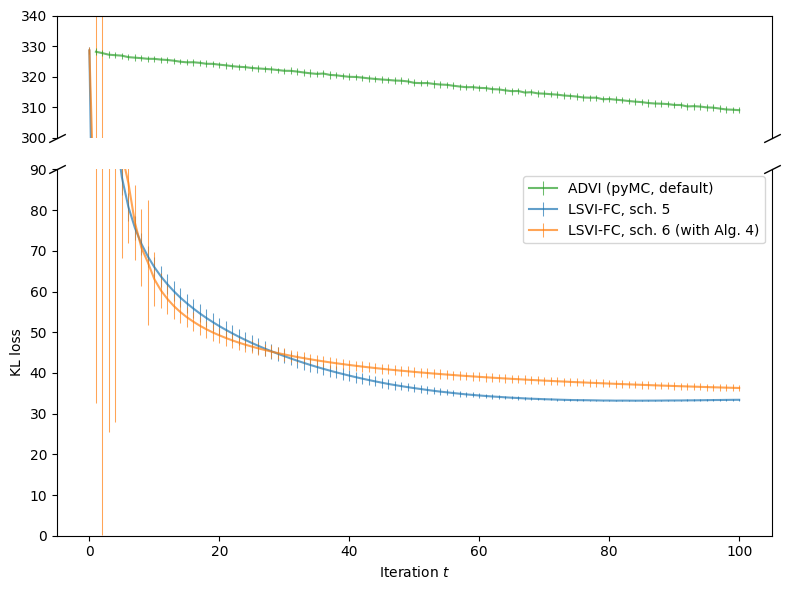

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# labels and data (assuming lossesPKLs is already defined)
labels = ["LSVI-FC, sch. 5", "LSVI-FC, sch. 6 (with Alg. 4)", "ADVI (pyMC, default)"]

start = 0
end = 101

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6),
                               gridspec_kw={'height_ratios': [1, 3]})

offset = 60

# --- Plot all 3 curves on top axis (emphasizing shared start) ---
for idx in range(3):
    ax1.errorbar(np.arange(start, end) if idx != 2 else np.arange(start+1, end), 
                 lossesPKLs[idx].mean(axis=0)[start:end] + offset, 
                 yerr=lossesPKLs[idx].std(axis=0)[start:end],
                 label=labels[idx] if idx==2 else None, alpha=0.7, elinewidth=0.75)

ax1.set_ylim(300, 340)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelbottom=False, bottom=False)

# --- Plot only first two curves on bottom axis (detailed zoom) ---
for idx in range(2):
    ax2.errorbar(np.arange(start, end), 
                 lossesPKLs[idx].mean(axis=0) + offset, 
                 yerr=lossesPKLs[idx].std(axis=0),
                 label=labels[idx], alpha=0.7, elinewidth=0.75)

ax2.set_ylim(0, 90)
ax2.set_xlabel(r"Iteration $t$")
ax2.set_ylabel("KL loss")

# --- Combine legends ---
handles1, labels1_ = ax1.get_legend_handles_labels()
handles2, labels2_ = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1_ + labels2_, loc="upper right")

# --- Visual axis break ---
ax2.spines['top'].set_visible(False)
d = .5  # size of break marker
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)  # Top plot break lines
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)  # Bottom plot break lines

plt.tight_layout()
plt.savefig("lossesPKL_with_break_and_dual_view.pdf", dpi=300)
plt.savefig("Sonar.pdf", dpi=300)